In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from dataloader import get_data, get_data_3d
from sklearn.model_selection import train_test_split

#import eli5
#from eli5.sklearn import PermutationImportance

# ToDo list
* backpropagate to find what features are important
* think about feature vector
* maybe angle as 2d matrix - one hot encoding
* classification (cscd, trck, muon, noise?)
* speed up file reader / parallelize
* sparse / ragged array w/ tf v 2.1

In [3]:
tf.test.is_gpu_available()

True

In [4]:
import h5py


In [5]:
h = h5py.File('../test_data/oscNext_genie_level3_v01.03_pass2.120000.000000.hdf5', 'r')

In [6]:
t = np.asanyarray(h['MCInIcePrimary'])[['Event', 'x']]

In [7]:
t['x']

array([  64.8602006 ,   36.34829112,   36.69151319, ...,   93.83251081,
        -52.64937461, -159.68315717])

In [8]:
def angular_dist(zen_true, az_true, zen_pred, az_pred):
    dd = tf.math.cos(zen_pred) * tf.math.cos(zen_true) + tf.math.sin(zen_pred) * tf.math.sin(zen_true) * tf.math.cos(az_pred - az_true)
    dd = tf.clip_by_value(dd, -1., 1.)
    return tf.math.acos(dd)

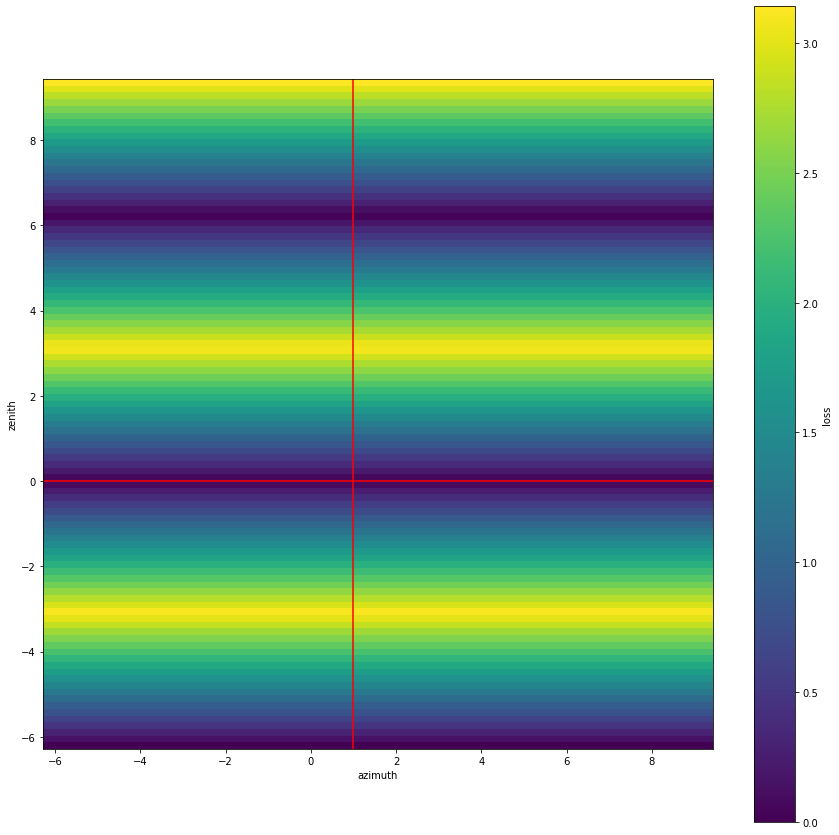

In [9]:
zenith = np.linspace(-2*np.pi, 3*np.pi, 100)
azimuth = np.linspace(-2*np.pi, 3*np.pi, 100)

zenzen, azaz = np.meshgrid(zenith, azimuth)

true = [0, 1]

loss = angular_dist(np.array(true[0], dtype=np.float64), np.array(true[1], dtype=np.float64), zenzen.T, azaz.T)

fig, ax = plt.subplots(1, 1, figsize=(15,15))
im = ax.imshow(loss, extent=(azimuth[0], azimuth[-1], zenith[0], zenith[-1]), origin='lower')
ax.axhline(true[0], color='r')
ax.axvline(true[1], color='r')

ax.set_xlabel('azimuth')
ax.set_ylabel('zenith')

cbar = fig.colorbar(im, )
cbar.set_label('loss')

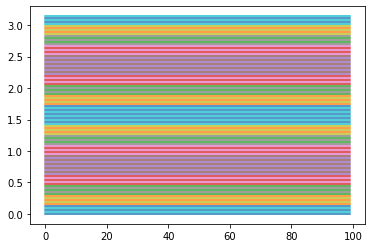

In [10]:
plt.plot(np.asarray(loss).T);

In [11]:
def my_loss(y_true, y_pred, sample_weight=1.):

    # vertex

    #if sample_weight is None:
    #sample_weight = 1.

    dist = tf.math.sqrt(tf.square(y_pred[:,0] - y_true[:,0]) / 25. + tf.square(y_pred[:,1] - y_true[:,1]) / 25. + tf.square(y_pred[:,2] - y_true[:,2]) / 15.) / 3.
    # Huber
    delta = 1.
    mask = dist < delta
    p1 = 0.5 * tf.square(dist[mask])
    p2 = delta * (dist[~mask] - 0.5*delta)

    vertex_loss =  tf.reduce_mean(tf.concat([p1, p2], axis=0)  )# * sample_weight)

    ad = angular_dist(y_true[:,3], y_true[:,4], y_pred[:,3], y_pred[:, 4])

    #angular_loss = tf.sqrt(tf.reduce_mean(tf.square(ad))) * 2.

    angular_loss = tf.reduce_mean(tf.abs(ad) )#* sample_weight)

    #angular_loss = tf.reduce_mean(tf.math.square(tf.math.acos(tf.math.cos(y_pred[:,3]) * tf.math.cos(y_true[:,3]) + tf.math.sin(y_pred[:,3]) * tf.math.sin(y_true[:,3]) * tf.math.cos(y_pred[:,4] - y_true[:,4]))), axis=0)

    energy_loss = tf.sqrt(tf.reduce_mean(tf.math.square(y_pred[:,5] - y_true[:,5]) ))#* sample_weight)) / 50.

    return energy_loss #+ angular_loss + vertex_loss   #vertex_loss + angular_loss + energy_loss

In [12]:
def huber(x, delta):
    '''calculate huber loss'''
    mask = x < delta
    p1 = 0.5 * tf.square(x[mask])
    p2 = delta * (x[~mask] - 0.5*delta)
    return tf.concat([p1, p2], axis=0)

In [13]:
def e_loss(pred, true):
    #penalty = tf.dtypes.cast(pred < 0., dtype=pred.dtype) * 20.
    diff = tf.abs(pred - true) #/ 10
    return diff #+ penalty

In [14]:
def v_loss(x_pred, y_pred, z_pred, x_true, y_true, z_true):
    dist = tf.math.sqrt(tf.square((x_pred - x_true)/25.)  + tf.square((y_pred - y_true)/25.)  + tf.square((z_pred - z_true))/15.)
    return huber(dist, 1.)

In [15]:
def t_loss(time_pred, time_true):
    return huber(tf.abs(time_pred - time_true), 1.)

In [ ]:
#def d_loss(dir_x_pred, dir_y_pred, dir_z_pred, dir_x_true, dir_y_true, dir_z_true):
#    norm = tf.sqrt(tf.square(dir_x_pred) + tf.square(dir_y_pred) + tf.square(dir_z_pred))


In [344]:
def a_loss(zen_true, az_true, zen_pred, az_pred):
    
    dist = angular_dist(zen_true, az_true, zen_pred, az_pred)
    
    return dist 

    # penalty term for wrong branch
    
    az_dist = tf.abs((az_true - az_pred))
    zen_dist = tf.abs((zen_true - zen_pred))

    return tf.square(zen_dist) + tf.square(az_dist)
    return tf.square(tf.square(zen_dist) + tf.square(az_dist))
    
    az_mask = tf.dtypes.cast((az_dist > 2 * np.pi), dtype=dist.dtype)
    az_penalty = az_mask * (az_dist)
                             
    zen_mask = tf.dtypes.cast((zen_dist > np.pi), dtype=dist.dtype)
    zen_penalty = zen_mask * (zen_dist)
                     
    dist_mask = (1. - az_mask) * (1. - zen_mask)
    
    
    #az_b = tf.abs(((az_true - az_pred) + np.pi) // (2 * np.pi)) == 0.
    #zen_b =  tf.abs(zen_true - zen_pred) // (0.5 * np.pi) == 0.
    
    return dist * dist_mask + (1 - dist_mask) * (az_penalty + zen_penalty)
    
    
    #dd = taylor_sin(zen_pred) * tf.math.sin(zen_true) + taylor_cos(zen_pred) * tf.math.cos(zen_true) * tf.math.cos(az_pred - az_true)

    #return dd
    
    # if angular distance > pi / 2 -> extend loss at pi/2 linearly in az and zen
    
    az_dist = tf.abs((az_true - az_pred) * tf.abs(tf.math.cos(zen_true)))
    #az_dist = tf.maximum(az_dist, np.pi) - np.pi
    
    
    zen_dist = tf.abs(zen_true - zen_pred) * (1 + tf.abs(tf.math.sin(zen_true))) * 0.5
    #zen_dist = tf.maximum(zen_dist, 0.5 * np.pi) - 0.5 * np.pi
    
    lin_term = tf.sqrt(tf.square(az_dist) + tf.square(zen_dist)) #- 0.5 * np.pi
    
    return lin_term
    
    #mask = tf.dtypes.cast((dist > 0.5 * np.pi) | (lin_term > 0.25 * np.pi) , dtype=dist.dtype)
    
    #dist = dist * ( 1. - mask) + mask * lin_term
    
    #masked_dist = tf.boolean_mask(dist, mask)
    
    #masked_dist = masked_dist + tf.boolean_mask(lin_term, mask)
    
    return dist

    

In [402]:
x_idx = labels.index('x')
y_idx = labels.index('y')
z_idx = labels.index('z')
time_idx = labels.index('time')
azimuth_idx = labels.index('azimuth')
zenith_idx = labels.index('zenith')
energy_idx = labels.index('energy')
dir_x_idx = labels.index('dir_x')
dir_y_idx = labels.index('dir_y')
dir_z_idx = labels.index('dir_z')



def my_loss(y_true, y_pred, sample_weight=1.):

    vertex_loss = v_loss(y_pred[:,x_idx], y_pred[:,y_idx], y_pred[:,z_idx], y_true[:,x_idx], y_true[:,y_idx], y_true[:,z_idx]) 

    time_loss = t_loss(y_pred[:,time_idx], y_true[:,time_idx])
    
    angular_loss = a_loss(y_true[:,zenith_idx], y_true[:,azimuth_idx], y_pred[:,zenith_idx], y_pred[:, azimuth_idx])
    
    #angular_loss = d_loss(y_pred[:,dir_x_idx], y_pred[:,dir_y_idx], y_pred[:,dir_z_idx], y_true[:,dir_x_idx], y_true[:,dir_y_idx], y_true[:,dir_z_idx])
        
    energy_loss = e_loss(y_pred[:,energy_idx], y_true[:,energy_idx])

    
    return (vertex_loss + time_loss) * sample_weight
    #return (energy_loss + angular_loss + vertex_loss + time_loss) * sample_weight

In [346]:
X, y = get_data(
    '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000120.hdf5',
    features = ['charge'],
    labels = ['z'],
    sparse=True,
    ragged=False,
    N_events=2,
    )

N_events, N_channels, max_pulses, N_features = X.shape
_, N_labels = y.shape

100%|██████████| 2/2 [00:00<00:00, 408.09it/s]

max pulses =  146


In [9]:
!ls ../test_data/

oscNext_genie_level3_v01.03_pass2.120000.000000.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000020.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000030.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000040.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000050.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000060.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000070.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000080.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000090.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000110.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000120.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000130.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000140.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000150.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000160.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000170.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000190.hdf5
oscNext_genie_level3_v01.03_pass2.120000.000200.hdf5
oscNext_genie_level3_v01.03_pass2.120000.00021

In [350]:
labels = ['x', 'y', 'z', 'time', 'zenith', 'azimuth', 'energy', 'dir_x', 'dir_y', 'dir_z']
reco_labels = labels[:-1]

Xs = []
ys = []
rs = []


for i in range(10):
    #fname = '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000%s0.hdf5'%('%s'%i).zfill(2)
    fname = '../test_data/oscNext_genie_level3_v01.03_pass2.140000.000%s00.hdf5'%i
    try:
        X, y, r = get_data_3d(
            fname,
            labels = labels,
            reco_labels = reco_labels,
            N_events=None,
            min_pulses=10,
            )
        Xs.append(X)
        ys.append(y)
        rs.append(r)
    except OSError:
        print('Skipping file %s'%fname)
        #raise Exception

X = np.concatenate(Xs)
y = np.concatenate(ys)
r = np.concatenate(rs)
    
r = np.nan_to_num(r)
    
w = np.sum(X[:,:,0], axis=1)

N_events, N_channels, N_features = X.shape
_, N_labels = y.shape



Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.000000.hdf5


100%|██████████| 9082/9082 [00:24<00:00, 378.00it/s]


In [351]:
labels

['x',
 'y',
 'z',
 'time',
 'zenith',
 'azimuth',
 'energy',
 'dir_x',
 'dir_y',
 'dir_z']

In [352]:
#np.save('../test_data/X.npy', X)
#np.save('../test_data/y.npy', y)

In [353]:
X_train, X_test, y_train, y_test, w_train, w_test, r_train, r_test = train_test_split(X, y, w, r, test_size=0.1, random_state=42)

In [354]:
energy_idx = labels.index('energy')

y_train[:, energy_idx] = np.log(y_train[:, energy_idx])
y_test[:, energy_idx] = np.log(y_test[:, energy_idx])

#r_train[:, energy_idx] = np.log(r_train[:, energy_idx])
#r_test[:, energy_idx] = np.log(r_test[:, energy_idx])


In [371]:
class trafo(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(trafo, self).__init__()
        self.num_outputs = num_outputs

    def call(self, input):
    
        norm = tf.sqrt(tf.square(input[:, dir_x_idx]) + tf.square(input[:, dir_y_idx]) + tf.square(input[:, dir_z_idx]))

        dir_x = input[:, dir_x_idx] / norm
        dir_y = input[:, dir_y_idx] / norm
        dir_z = input[:, dir_z_idx] / norm

        zen = tf.acos(dir_z)
        az = tf.atan2(dir_y, dir_x) % (2 * np.pi)

        out =  tf.concat([input[:,:4], zen[:, tf.newaxis], az[:, tf.newaxis], input[:, 6][:, tf.newaxis], dir_x[:, tf.newaxis], dir_y[:, tf.newaxis], dir_z[:, tf.newaxis]], axis=1)

        #print(out)

        return out

In [403]:

#d_lstm = 1

#activation=tf.nn.leaky_relu
activation='relu'

max_pulses=None

# with LSTM
#inputs = tf.keras.Input(shape=(N_channels, max_pulses, N_features))#, sparse=True)
#h0 = tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(d_lstm, activation='relu', input_shape=(max_pulses, N_features)), input_shape=(N_channels, max_pulses, N_features), )(inputs, )

# without LSTM, simple sum over time
inputs = tf.keras.Input(shape=(N_channels, N_features), )


h = tf.keras.layers.Reshape((86, 60 * N_features))(inputs)
#h1 = tf.keras.layers.Reshape((86, 60, N_features, 1))(h0)

h = tf.keras.layers.Dropout(0.01)(h)

ic = tf.keras.layers.Lambda(lambda x: x[:, :78])(h)
dc = tf.keras.layers.Lambda(lambda x: x[:, 78:])(h)

#h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(2, (8, 1), activation=activation, input_shape=(60, N_features, 1)), input_shape=(78,60, N_features, 1))(ic)
#h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(2, (8, 1), activation=activation, input_shape=(60, N_features, 1)), input_shape=(8,60, N_features, 1))(dc)

#h_dc = tf.keras.layers.Reshape((8, 53*7*2))(h_dc)
#h_ic = tf.keras.layers.Reshape((78, 53*7*2))(h_ic)

h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation=activation, input_shape=(60 * N_features,)), input_shape=(78, 60 * N_features))(ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation=activation, input_shape=(60 * N_features,)), input_shape=(8, 60 * N_features))(dc)

#h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation=activation, input_shape=(64,)), input_shape=(78,64))(h_ic)
#h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation=activation, input_shape=(64,)), input_shape=(8,64))(h_dc)

h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(64,)), input_shape=(78,64))(h_ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(64,)), input_shape=(8,64))(h_dc)


h = tf.keras.layers.Concatenate(axis=1)([h_ic, h_dc])

h = tf.keras.layers.Flatten(input_shape=(86, 16))(h)

h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)
h = tf.keras.layers.Dense(32, activation=activation)(h)

outputs = tf.keras.layers.Dense(N_labels, activation='linear')(h)

outputs = trafo(N_labels)(outputs)
#converted_outputs = tf.keras.layers.Lambda(lambda x: tf.concat([x[:4], , az, x[6:]))(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

loss_history = []
val_loss_history = []

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_70 (InputLayer)           [(None, 5160, 7)]    0                                            
__________________________________________________________________________________________________
reshape_92 (Reshape)            (None, 86, 420)      0           input_70[0][0]                   
__________________________________________________________________________________________________
dropout_188 (Dropout)           (None, 86, 420)      0           reshape_92[0][0]                 
__________________________________________________________________________________________________
lambda_132 (Lambda)             (None, 78, 420)      0           dropout_188[0][0]                
___________________________________________________________________________________________

In [404]:
#optimizer = tf.keras.optimizers.SGD(0.001) #, clipnorm=1) # bad
optimizer = tf.keras.optimizers.RMSprop(0.001, )
#optimizer = tf.keras.optimizers.Nadam(0.001)
#optimizer = tf.keras.optimizers.Adam(0.001)

#model.compile(loss=angular_dist_loss, optimizer="sgd", )
model.compile(loss=my_loss, optimizer=optimizer)

In [405]:
#sample_weights_train = np.sqrt(w_train)
#sample_weights_test = np.sqrt(w_test)

sample_weights_train = np.ones_like(w_train)
sample_weights_test = np.ones_like(w_test)

In [406]:
model.fit(X_train, y_train, sample_weight=sample_weights_train, batch_size=512, epochs=30, validation_data=(X_test, y_test, sample_weights_test), )
#model.fit(X_train, y_train, batch_size=512, epochs=30, validation_data=(X_test, y_test))

loss_history.append(model.history.history['loss'])
val_loss_history.append(model.history.history['val_loss'])

Train on 74263 samples, validate on 8252 samples
Epoch 1/30
74263/74263 [==============================] - 9s 127us/sample - loss: 51.2452 - val_loss: 27.4249
Epoch 2/30
74263/74263 [==============================] - 4s 60us/sample - loss: 24.5879 - val_loss: 21.9388
Epoch 3/30
74263/74263 [==============================] - 5s 61us/sample - loss: 20.1959 - val_loss: 17.9708
Epoch 4/30
74263/74263 [==============================] - 4s 59us/sample - loss: 18.2887 - val_loss: 19.0683
Epoch 5/30
74263/74263 [==============================] - 4s 58us/sample - loss: 17.2677 - val_loss: 18.2764
Epoch 6/30
74263/74263 [==============================] - 5s 61us/sample - loss: 16.5995 - val_loss: 16.0498
Epoch 7/30
74263/74263 [==============================] - 4s 55us/sample - loss: 16.0750 - val_loss: 15.9922
Epoch 8/30
74263/74263 [==============================] - 4s 59us/sample - loss: 15.6993 - val_loss: 15.6321
Epoch 9/30
74263/74263 [==============================] - 5s 61us/sample - los

In [407]:
#X_importance_test = np.copy(X_test)
#X_importance_test[:,:,1] = 0.

x : width =  63.47323989868164  median =  4.522887229919434
y : width =  62.97838068008423  median =  -2.0357742309570312
z : width =  45.85368728637695  median =  3.4659805297851562
time : width =  0.8065037429332733  median =  -1.0119288563728333
zenith : width =  1.0621100068092346  median =  0.2882993817329407
azimuth : width =  3.1470034420490265  median =  -0.04678630828857422


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


energy : width =  22.161442756652832  median =  38.97907829284668
dir_x : width =  1.0067286938428879  median =  -0.8885080218315125
dir_y : width =  0.9794850423932076  median =  0.004551008343696594
dir_z : width =  1.0019438788294792  median =  -0.2748422771692276


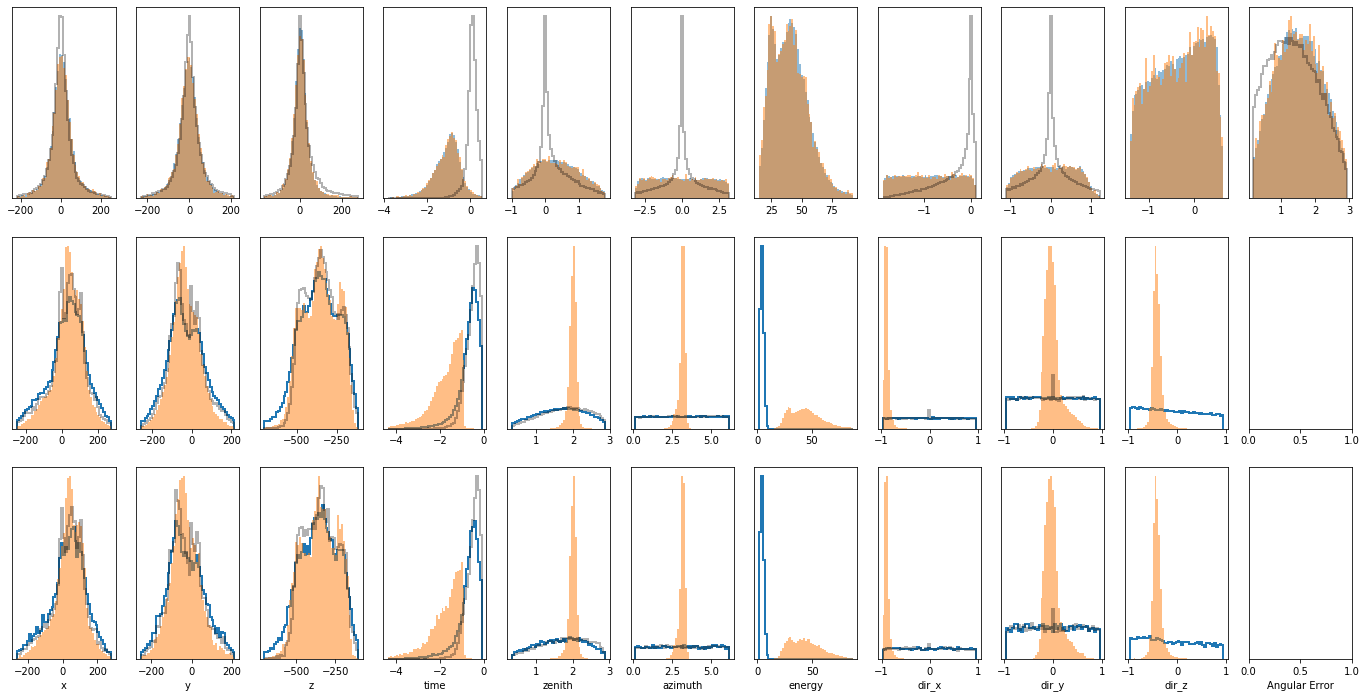

In [408]:
#y_pred_test = model.predict(X_importance_test, batch_size=512)
y_pred_test = model.predict(X_test, batch_size=512)
y_pred_train = model.predict(X_train, batch_size=512)
    
err_test = y_pred_test - y_test
err_train = y_pred_train - y_train

#plot_weights_train = np.ones_like(w_train)
#plot_weights_test = np.ones_like(w_test)

plot_weights_train = sample_weights_train
plot_weights_test = sample_weights_test


if 'azimuth' in labels and 'zenith' in labels:
    N_subplots = N_labels + 1
else:
    N_subplots = N_labels

fig, ax = plt.subplots(nrows=3, ncols=N_subplots, figsize=(24,12))
    
qs = [0.01, 0.99]
    
for i in range(N_labels):
    
    reco = False
    if labels[i] in reco_labels:
        reco = True
        r_idx = reco_labels.index(labels[i])
        err_reco_test = r_test[:, r_idx] - y_test[:, i]
        err_reco_train = r_train[:, r_idx] - y_train[:, i]
    
    
    lo, up = np.quantile(np.concatenate([err_train[:,i], err_test[:,i]]), qs)
    bins = np.linspace(lo, up, 50)
    
    ax[0, i].hist(err_train[:,i], bins=bins, alpha=0.5, density=True, weights=plot_weights_train)
    ax[0, i].hist(err_test[:,i], bins=bins, alpha=0.5, density=True, weights=plot_weights_test)
    
    if reco:
        ax[0, i].hist(np.concatenate([err_reco_train, err_reco_test]), bins=bins, histtype='step', lw=2, color='k', alpha=0.3, density=True, weights=np.concatenate([plot_weights_train, plot_weights_test]))
    
    ax[0, i].get_yaxis().set_visible(False)

    lo, up = np.quantile(np.concatenate([y_pred_train[:,i], y_train[:,i]]), qs)
    bins = np.linspace(lo, up, 50)
    ax[1, i].hist(y_train[:,i], bins=bins, histtype='step', lw=2, density=True, weights=plot_weights_train)
    ax[1, i].hist(y_pred_train[:,i], bins=bins, alpha=0.5, density=True, weights=plot_weights_train) 
    
    if reco:
        ax[1, i].hist(r_train[:, r_idx], bins=bins, histtype='step', lw=2, color='k', alpha=0.3, density=True, weights=plot_weights_train) 
    
    ax[1, i].get_yaxis().set_visible(False)

    lo, up = np.quantile(np.concatenate([y_pred_test[:,i], y_test[:,i]]), qs)
    bins = np.linspace(lo, up, 50)
    ax[2, i].hist(y_test[:,i], bins=bins, histtype='step', lw=2, density=True, weights=plot_weights_test)
    ax[2, i].hist(y_pred_test[:,i], bins=bins, alpha=0.5, density=True, weights=plot_weights_test)  
    
    if reco:
        ax[2, i].hist(r_test[:, r_idx], bins=bins, histtype='step', lw=2, color='k', alpha=0.3, density=True, weights=plot_weights_test) 
    
    ax[2, i].get_yaxis().set_visible(False)
    ax[2, i].set_xlabel(labels[i])
    
    q25, q50, q75 = np.quantile(err_test[:,i], [0.25, 0.5, 0.75])
    print(labels[i], ': width = ', q75 - q25, ' median = ',q50)
    
    
    
if N_subplots > N_labels:
    
    az_idx = labels.index('azimuth')
    zen_idx = labels.index('zenith')
    
    ad_error_train = angular_dist(y_train[:, zen_idx], y_train[:, az_idx], y_pred_train[:, zen_idx], y_pred_train[:, az_idx])
    ad_error_test = angular_dist(y_test[:, zen_idx], y_test[:, az_idx], y_pred_test[:, zen_idx], y_pred_test[:, az_idx])
    
    lo, up = np.quantile(np.concatenate([ad_error_train, ad_error_test]), qs)
    bins = np.linspace(lo, up, 50)
    
    ax[0, -1].hist(ad_error_train, bins=bins, alpha=0.5,  density=True, weights=plot_weights_train)
    ax[0, -1].hist(ad_error_test, bins=bins, alpha=0.5, density=True, weights=plot_weights_test)
    
    if 'zenith' in reco_labels and 'azimuth' in reco_labels:
        r_az_idx = reco_labels.index('azimuth')
        r_zen_idx = reco_labels.index('zenith')
        ad_error_train = angular_dist(y_train[:, zen_idx], y_train[:, az_idx], r_train[:, r_zen_idx], y_pred_train[:, az_idx])
        ad_error_test = angular_dist(y_test[:, zen_idx], y_test[:, az_idx], r_test[:, r_zen_idx], y_pred_test[:, az_idx])
        ax[0, -1].hist(np.concatenate([ad_error_test, ad_error_train]), bins=bins, histtype='step', lw=2, color='k', alpha=0.3, density=True, weights=np.concatenate([plot_weights_test, plot_weights_train]))
        
    
    ax[0, -1].get_yaxis().set_visible(False)   
    ax[1, -1].get_yaxis().set_visible(False)
    ax[2, -1].get_yaxis().set_visible(False)
    
    ax[2, -1].set_xlabel('Angular Error')

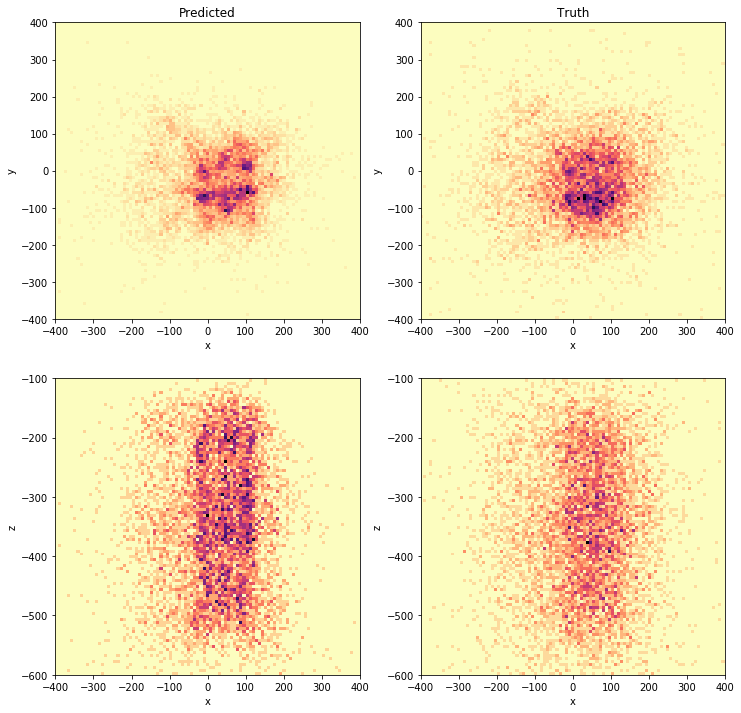

In [177]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

n_bins = 100
cmap = 'magma_r'

x_bins = np.linspace(-400,400, n_bins)
y_bins = np.linspace(-400,400, n_bins)
z_bins = np.linspace(-600,-100, n_bins)


ax[0,0].hist2d(y_pred_test[:,0], y_pred_test[:,1], bins=(x_bins, y_bins), cmap=cmap);
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('y')
ax[0,0].set_title('Predicted')
ax[0,1].hist2d(y_test[:,0], y_test[:,1], bins=(x_bins, y_bins), cmap=cmap);
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('y')
ax[0,1].set_title('Truth')

ax[1,0].hist2d(y_pred_test[:,0], y_pred_test[:,2], bins=(x_bins, z_bins), cmap=cmap);
ax[1,0].set_xlabel('x')
ax[1,0].set_ylabel('z')
ax[1,1].hist2d(y_test[:,0], y_test[:,2], bins=(x_bins, z_bins), cmap=cmap);
ax[1,1].set_xlabel('x')
ax[1,1].set_ylabel('z')

plt.savefig('vertex.png', dpi=300)

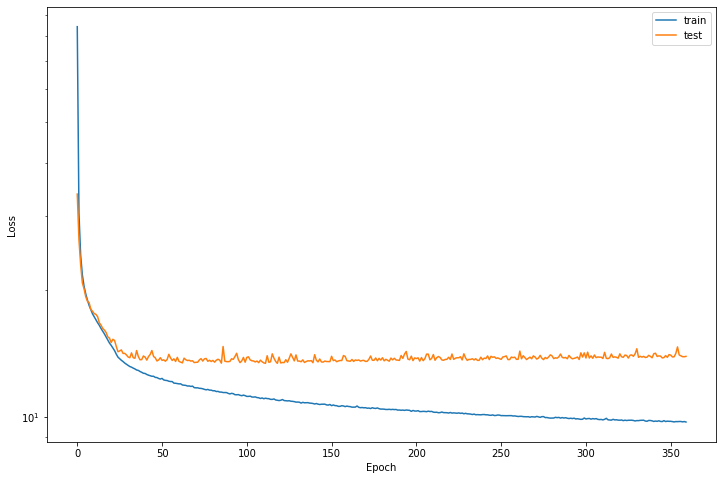

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax.plot(np.concatenate(loss_history), label='train')
ax.plot(np.concatenate(val_loss_history), label='test')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

In [130]:
np.where(np.sum(X[:,:,1], axis = (1,)) > 40)

(array([   24,    49,    50, ..., 82512, 82513, 82514]),)

In [131]:
np.where(np.sum(X[467], axis=1) > 20)

(array([], dtype=int64),)

In [132]:
test = np.arange(5160)

In [1068]:
tf.reshape(test, (86,60))

<tf.Tensor: id=1344558, shape=(86, 60), dtype=int64, numpy=
array([[   0,    1,    2, ...,   57,   58,   59],
       [  60,   61,   62, ...,  117,  118,  119],
       [ 120,  121,  122, ...,  177,  178,  179],
       ...,
       [4980, 4981, 4982, ..., 5037, 5038, 5039],
       [5040, 5041, 5042, ..., 5097, 5098, 5099],
       [5100, 5101, 5102, ..., 5157, 5158, 5159]])>

In [867]:
X[467, 5130:5145]

array([[ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 5.250e-01,  1.000e+00,  1.780e-01,  1.780e-01,  1.780e-01],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 1.275e+00,  1.000e+00,  5.500e-02,  5.500e-02,  5.500e-02],
       [ 1.275e+00,  1.000e+00,  1.800e-02,  1.800e-02,  1.800e-02],
       [ 1.275e+00,  1.000e+00,  1.160e-01,  1.160e-01,  1.160e-01],
       [ 4.900e+00,  2.000e+00, -4.100e-02, -3.700e-02, -3.300e-02],
       [ 9.950e+00,  4.000e+00, -8.700e-02, -7.250e-02, -1.300e-02],
       [ 3.390e+01,  4.000e+00, -1.130e-01, -1.035e-01, -6.500e-02],
       [ 4.868e+02,  2.800e+01, -1.390e-01, -5.000e-03,  2.854e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0

In [950]:
np.percentile([0,100,102,102,105], 99)

104.88

In [678]:
model.predict(X[[2098]])

array([[ 0.18823561,  2.9725177 , -3.9740937 ,  1.4606837 ,  4.8276844 ,
        -1.2033705 ]], dtype=float32)

In [788]:
y_pred_test[300]

array([ 5.5249645e+01, -5.0096516e+01, -5.1649866e+02,  2.3528700e+00,
        3.7410338e+00,  1.2494776e-10], dtype=float32)

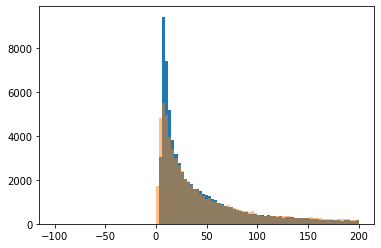

In [957]:
plt.hist(np.exp(y_pred_train[:,5]), bins=np.linspace(-100, 200, 100));
plt.hist(np.exp(y_train[:,5]), bins=np.linspace(-100, 200, 100), alpha=0.5);

In [185]:
np.where(np.bincount(np.arange(-3,10)) > 0)

ValueError: 'list' argument must have no negative elements

In [189]:
tf.reshape(np.arange(120), (2,60))

<tf.Tensor: id=340172, shape=(2, 60), dtype=int64, numpy=
array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59],
       [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]])>

In [215]:

set([1,2,3]).difference(set([5]))

{1, 2, 3}